<a href="https://colab.research.google.com/github/NoeZGravity/IS403.N21.HTTT-Nhom9/blob/20521688-DinhThiAnhNguyet/DELL_Seq2seq_631.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1. Import các thư viện cần thiết
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv và gắn index với giá Close
data=pd.read_csv("/content/drive/MyDrive/DataFiles/DataFinal/DELL.csv")
data1=data.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
data1=scaler.fit_transform(np.array(data1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(data1))
test_size = int(0.3 * len(data1))
val_size = len(data1) - train_size - test_size

train_data = data1[:train_size]
test_data = data1[train_size:train_size+test_size]
val_data = data1[train_size+test_size:]


In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100

train_X, train_Y = create_dataset(train_data, time_step)
test_X, test_Y = create_dataset(test_data, time_step)
valid_X, valid_Y = create_dataset(val_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for seq2seq
train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)
valid_X = valid_X.reshape(valid_X.shape[0],valid_X.shape[1] , 1)

In [ ]:
#8. Xây dựng mô hình Seq2Seq
model = Sequential()
model.add(LSTM(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')


In [ ]:
#9. Huấn luyện mô hình
model.fit(train_X, train_Y,validation_data=(test_X,test_Y), epochs=50, batch_size=32)

Epoch 1/50
23/23 [==============================] - 4s 76ms/step - loss: 0.0158 - val_loss: 0.0319
Epoch 2/50
23/23 [==============================] - 1s 44ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 3/50
23/23 [==============================] - 1s 45ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 4/50
23/23 [==============================] - 1s 45ms/step - loss: 8.5438e-04 - val_loss: 0.0031
Epoch 5/50
23/23 [==============================] - 2s 91ms/step - loss: 7.9371e-04 - val_loss: 0.0036
Epoch 6/50
23/23 [==============================] - 2s 90ms/step - loss: 7.7970e-04 - val_loss: 0.0033
Epoch 7/50
23/23 [==============================] - 1s 46ms/step - loss: 7.6980e-04 - val_loss: 0.0036
Epoch 8/50
23/23 [==============================] - 1s 45ms/step - loss: 7.2865e-04 - val_loss: 0.0024
Epoch 9/50
23/23 [==============================] - 1s 45ms/step - loss: 7.5351e-04 - val_loss: 0.0035
Epoch 10/50
23/23 [==============================] - 1s 45ms/step - loss: 6.9693e-04 

In [ ]:
# 10. Dự báo dữ liệu train, test, val
train_predict=model.predict(train_X)
y_pred=model.predict(test_X)
y_pred_val=model.predict(valid_X)

2/2 [==============================] - 0s 19ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - valid_Y)**2))
test_rmse = np.sqrt(np.mean((y_pred - test_Y)**2))
valid_mae = np.mean(np.abs((y_pred_val - valid_Y)))
test_mae = np.mean(np.abs((y_pred - test_Y)))
valid_mape = np.mean(np.abs((y_pred_val - valid_Y)/valid_Y))
test_mape = np.mean(np.abs((y_pred - test_Y)/test_Y))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 44.518222865620125
Testing RMSE: 48.78510970697299
Validation MAE: 44.48669005935715
Testing MAE: 48.222631007375156
Validation MAPE: 66.75497547217927
Testing MAPE: 68.40831966867691


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<30):

    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.729631]
101
1 day input [0.57236487 0.56261139 0.56109418 0.57128118 0.55654259 0.55004022
 0.5632616  0.57648298 0.60227543 0.59837413 0.57063088 0.59295554
 0.58970434 0.59403923 0.6087778  0.62351639 0.61549681 0.61051171
 0.6087778  0.60357593 0.59078804 0.58905413 0.59382245 0.58471926
 0.57149788 0.56369508 0.55936021 0.55350811 0.54527192 0.52966636
 0.50647479 0.52316405 0.5021399  0.47873163 0.47548046 0.49672131
 0.49585431 0.50755849 0.48956881 0.51839567 0.53140035 0.50820879
 0.50257341 0.49303671 0.50625809 0.51319387 0.53075006 0.54678913
 0.55437511 0.57084767 0.56868019 0.56716298 0.55480862 0.58081785
 0.58450245 0.59035455 0.60726062 0.6209154  0.63500376 0.6690325
 0.63283636 0.61311261 0.6172308  0.6079108  0.58688665 0.58601966
 0.61051171 0.62546708 0.63261958 0.65299343 0.66166322 0.64042235
 0.6666483  0.68030317 0.6794362  0.67618509 0.65169304 0.65299343
 0.65667812 0.6664316  0.67661849 0.70414495 0.71779982 0.71324822
 0.68745567 0.67791899 0.7249524  0.

Validation RMSE: 44.518222865620125
Testing RMSE: 48.78510970697299
Validation MAE: 44.48669005935715
Testing MAE: 48.222631007375156
Validation MAPE: 66.75497547217927
Testing MAPE: 68.40831966867691


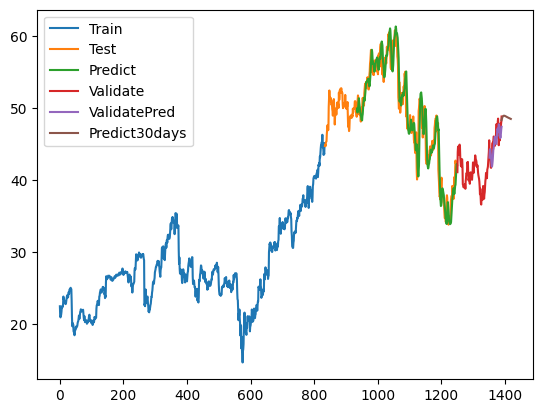

In [ ]:
# 14.Vẽ hình
import matplotlib.pyplot as plt
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+time_step+1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(data1)-1, stop=len(data1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()